# Tree Impact in Neighborhoods

This metric looks at trees managed by the city of Pittsburgh itself. Neighborhoods may have more trees than listed, but those trees are not owned by the city, and therefore can be bought and cut down to build the neighborhood's capital. None of those trees are safe from capitalism. The ones considered in this dataset are. Therefore, the neighborhood with the fewest city-protected trees per acre will most resemble Thneedville.

We will start by loading the data from WPRDC. This metric uses the [City of Pittsburgh Trees dataset](https://data.wprdc.org/dataset/city-trees) for tree data and the [Neighborhoods dataset](https://data.wprdc.org/dataset/neighborhoods2/resource/668d7238-cfd2-492e-b397-51a6e74182ff) for information on the size of neighborhoods.

In [1]:
import pandas as pd

trees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da")
hoods = pd.read_csv("https://data.wprdc.org/datastore/dump/668d7238-cfd2-492e-b397-51a6e74182ff")

print(trees.head)
print(hoods.head)

/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<bound method NDFrame.head of                id  address_number         street         common_name  \
0       754166088            7428  MONTICELLO ST               Stump   
1      1946899269             220     BALVER AVE  Linden: Littleleaf   
2      1431517397            2822      SIDNEY ST          Maple: Red   
3       994063598             608     SUISMON ST      Maple: Freeman   
4      1591838573            1135   N NEGLEY AVE       Maple: Norway   
...           ...             ...            ...                 ...   
45704    39047675  499 N LANG AVE     N LANG AVE       Maple: Norway   
45705  1827907131             NaN            NaN        Maple: Sugar   
45706  1513723611             NaN            NaN        Maple: Sugar   
45707  1830872418             NaN            NaN        Maple: Sugar   
45708   358553196             NaN            NaN        Maple: Sugar   

        scientific_name  height  width  growth_space_length  \
0                 Stump     0.0    0.0    

Looking at the trees dataset, there are a couple columns with useful information. I considered using stormwater benefits dollar value, air benefits dollar value, and simple tree count, but I decided to use the total pounds of air quality benefits per neighborhood. It seemed more objective, and there wasn't information about if the dollar value is objective from neighborhood to neighborhood. Additionally, terrible air quality is what makes Thneedville, Thneedville.

Let's isolate the important columns of the trees dataset, which are the neighboorhood a tree belongs to and the air quality benefits, and add up the total pounds of air quality benefits for each neighborhood:

In [2]:
trees2cols = pd.DataFrame({'airtotalval' : trees.groupby( 'neighborhood' )['air_quality_benfits_total_lbs'].agg('sum')}).reset_index()
trees2cols.head(3)

,neighborhood,airtotalval
0,Allegheny Center,2205.037779
1,Allegheny West,776.044207
2,Allentown,88.759047


Now, for visualization's sake, let's make a bar graph:

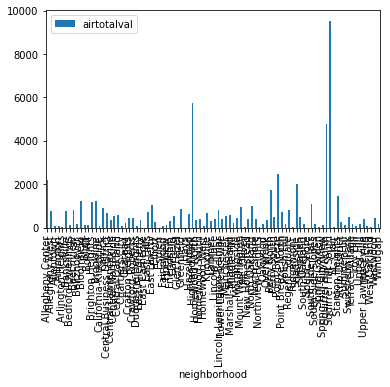

In [3]:
trees2cols.plot(kind = "bar", x = "neighborhood")

There are some with clearly higher numbers here, but we'll control for neighborhood size later. For now, let's make the data more readable by putting it into a map. To do this, we'll need to import geopandas, get our Pittsburgh map, and combine the map data and tree data:

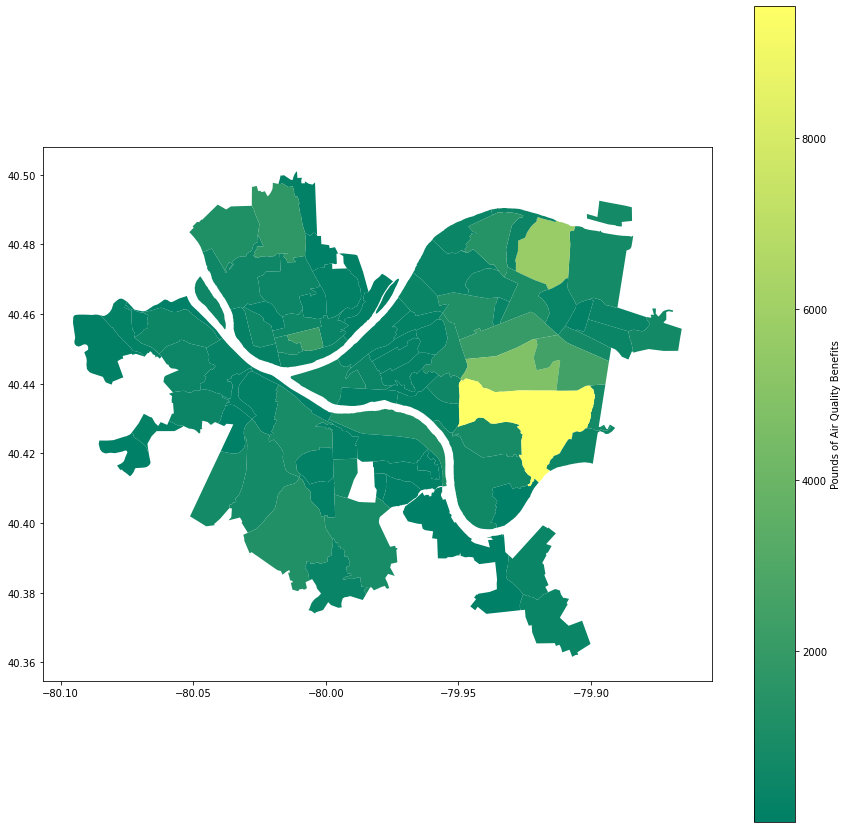

In [4]:
import geopandas

pittsburghmap = geopandas.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/dbd133a206cc4a3aa915cb28baa60fd4_0.zip")

airmap = pittsburghmap.merge(trees2cols, how = 'left', left_on = 'hood', right_on = 'neighborhood')
airmap.plot(column = "airtotalval", cmap = "summer", legend = True, figsize = (15,15), legend_kwds = {'label': "Pounds of Air Quality Benefits"})
            

Keep in mind, the more yellow areas have more pounds of benefits.

Now that we have this data, we need to standardize it. We can't fault a small neighborhood for having less tree benefits than a large neighborhood, because the large neighborhood has more room for more trees. To account for this, we need to find the amount of benefits per acre, and we do this by combining the above data and data about neighborhood sizes. First, we'll isolate the neighborhood and size in acres columns of the Neighborhood dataframe:

In [5]:
hoods2cols = pd.DataFrame( {'areaacres' : hoods.groupby('hood')['acres'].agg('sum')}).reset_index()
hoods2cols.head(3)

,hood,areaacres
0,Allegheny Center,134.703
1,Allegheny West,90.841
2,Allentown,189.608


Now, we'll combine it with the air quality benefits dataframe:

In [6]:
finalframe = pd.merge(trees2cols, hoods2cols, left_on="neighborhood", right_on="hood" ).drop("hood", axis=1)
finalframe.head(3)

,neighborhood,airtotalval,areaacres
0,Allegheny Center,2205.037779,134.703
1,Allegheny West,776.044207,90.841
2,Allentown,88.759047,189.608


I noticed that there wasn't an acres value for Hays, so I looked that up and input it myself. Then, I made a final column by dividng the pounds of air quality benefits per acre in each neighborhood, giving us a value for pounds per acre:

In [7]:
finalframe.at[60, "areaacres"] = 775.68
finalframe["poundsperacre"] = finalframe["airtotalval"].div(finalframe["areaacres"].values)
finalframe.head(3)

,neighborhood,airtotalval,areaacres,poundsperacre
0,Allegheny Center,2205.037779,134.703,16.369626
1,Allegheny West,776.044207,90.841,8.542885
2,Allentown,88.759047,189.608,0.468119


Since we want the neighborhood with the LEAST air quality benefits per acre, I sorted the data from least to greatest:

In [8]:
finalframe.sort_values(by = 'poundsperacre', ascending = True).head(10)

,neighborhood,airtotalval,areaacres,poundsperacre
37,Hays,0.288710,1125.478,0.000257
35,Glen Hazel,0.636481,293.197,0.002171
70,South Shore,0.495327,136.201,0.003637
30,Esplen,2.096283,147.829,0.014180
26,East Carnegie,7.037459,277.895,0.025324
57,Northview Heights,8.435484,201.558,0.041851
77,St. Clair,20.602310,199.285,0.103381
4,Arlington Heights,8.777274,84.592,0.103760
31,Fairywood,65.663695,622.746,0.105442
66,Ridgemont,34.193366,237.059,0.144240


With this data standardized, let's use it to make a new map:

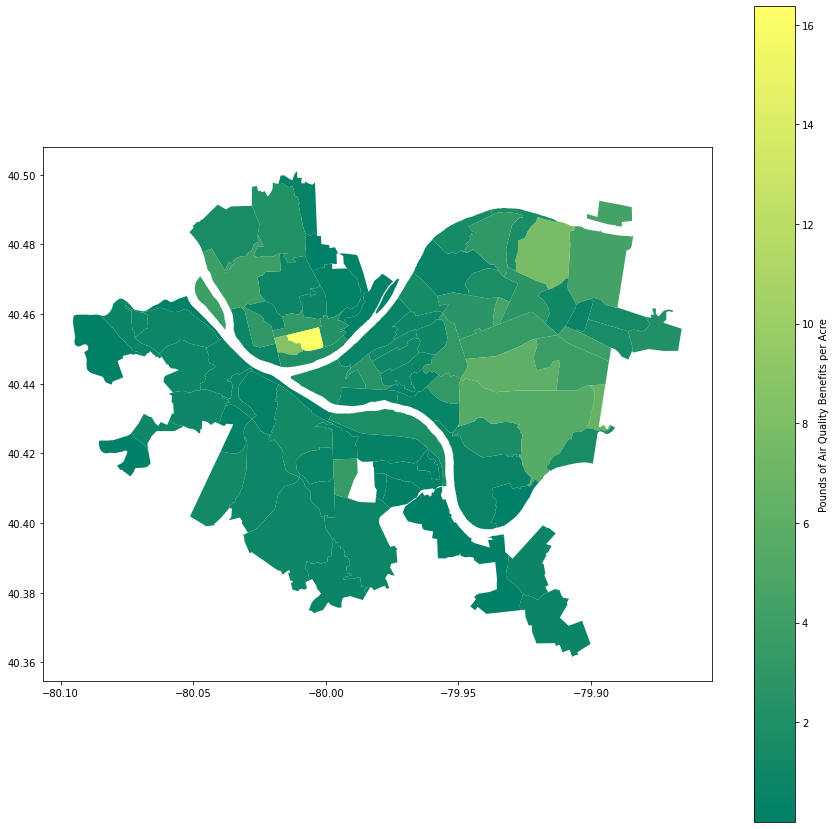

In [9]:
lbsperacremap = pittsburghmap.merge(finalframe, how = 'left', left_on = 'hood', right_on = 'neighborhood')
lbsperacremap.plot(column = "poundsperacre", cmap = "summer", legend = True, figsize = (15,15), legend_kwds = {'label': "Pounds of Air Quality Benefits per Acre"})

For this map, the darkest green areas have what we're looking for, the least pounds per acre of benefits.

To come up with a final score, I originally used the equation and code below to give each neighborhood a value between 0 and 100, but the top scores were very close to each other (top three were 99.998433, 99.986739, 99.977784).


In [10]:
# equation: 100 * (1 - neighborhood value / maximum value) = score

#maxval = finalframe.max()["poundsperacre"]
#finalframe["treescore"] = 100 * (1 - finalframe["poundsperacre"] / maxval )
#finalframe.sort_values(by = 'treescore', ascending = False).head(10)

Instead, I used the percentile to get a more even spread (values shown are times one hundred for more accuracy), and subtracted it from 100 so that neighborhoods in the lowest percentiles of pounds per acre had the highest scores, because remember, we are looking for the LEAST air quality benefits in a neighborhood.

In [11]:
finalframe['percentile'] = pd.qcut(finalframe['poundsperacre'], q = 10000, labels = False)

finalframe['treescore'] = 100 - finalframe['percentile']/100

finalframe.sort_values(by = 'treescore', ascending = False).head(10)

,neighborhood,airtotalval,areaacres,poundsperacre,percentile,treescore
37,Hays,0.288710,1125.478,0.000257,0,100.00
35,Glen Hazel,0.636481,293.197,0.002171,112,98.88
70,South Shore,0.495327,136.201,0.003637,224,97.76
30,Esplen,2.096283,147.829,0.014180,337,96.63
26,East Carnegie,7.037459,277.895,0.025324,449,95.51
57,Northview Heights,8.435484,201.558,0.041851,561,94.39
77,St. Clair,20.602310,199.285,0.103381,674,93.26
4,Arlington Heights,8.777274,84.592,0.103760,786,92.14
31,Fairywood,65.663695,622.746,0.105442,898,91.02
66,Ridgemont,34.193366,237.059,0.144240,1011,89.89


These above neighborhoods are the top ten neighborhoods for my metric. Let's take one last look at the map. The most yellow areas are the ones with the highest calculated score, and therefore fit the metric of "least air quality benefits from public trees per acre" the best:

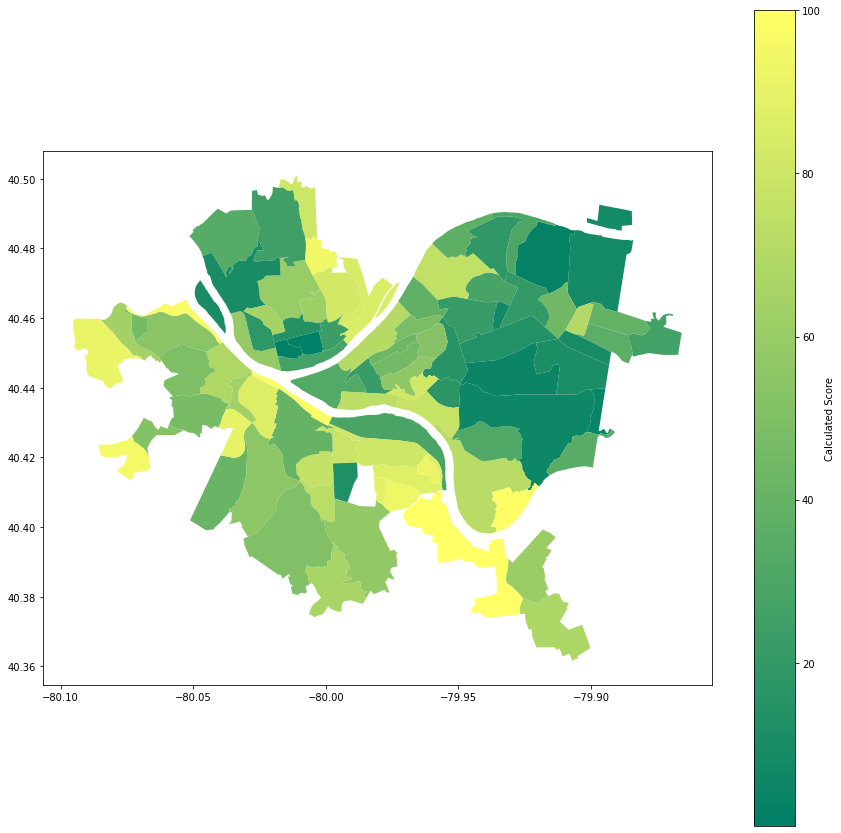

In [12]:
scoremap = pittsburghmap.merge(finalframe, how = 'left', left_on = 'hood', right_on = 'neighborhood')
scoremap.plot(column = "treescore", cmap = "summer", legend = True, figsize = (15,15), legend_kwds = {'label': "Calculated Score"})